In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import baltic as bt
import pickle
import seaborn as sns
import pandas as pd
%matplotlib inline

import matplotlib.patches as mpatches

In [2]:
tree_file = '../data/augur-output/dengue_allBranchEffects_tree.json'
tree = bt.loadJSON(tree_file, {'name': 'strain', 'height': 'xvalue'})
titered_strains = pd.read_csv('../data/katzelnick2015/processed/normalized_titers.csv', index_col=0)


titered_strains = set(titered_strains['virus'].values).union(set(titered_strains['sera'].values))

colors = pickle.load(open('./colors.p', 'rb'))


Tree height: 0.335580
Tree length: 7.088900
annotations present

Numbers of objects in tree: 4792 (2230 nodes and 2562 leaves)



In [3]:
titered_strains_tree = tree.reduceTree([k for k in tree.Objects if k.traits['strain'] in titered_strains])

In [4]:
def plot_tree(tree, ax, cax, colorby='cTiter'):
    branchWidth=2 ## default branch width
    ll = tree

    plt.yticks(size=0)
    
    cmap = plt.get_cmap(colors['cmap'])
    max_c = max([k.traits[colorby] for k in tree.Objects])
    norm = mpl.colors.Normalize(vmin=0, vmax=max_c)
    cb = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, orientation='vertical', 
                                   norm=norm, label="Cumulative log2(titer) distance from root")    
    cax.yaxis.set_label_position('left')
    cax.yaxis.set_ticks_position('left')

    cb.set_label("Cumulative log2(titer) distance from root", )
    
    for k in ll.Objects: ## iterate over objects in tree
        x=k.x ## or use absolute time instead
        y=k.y*1.5 ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.x ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x
            
        c = cmap(k.traits[colorby] / (max_c))
            
        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            s=50 ## tip size can be fixed
            s=50-30*k.height/ll.treeHeight
            
            plt.text(x*1.05, y, k.traits['strain'], fontsize=9, va='center')
            plt.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            plt.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
                        
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            plt.plot([x,x],[k.children[-1].y*1.5,k.children[0].y*1.5],lw=branchWidth,color=c,ls='-',zorder=9)
            
        plt.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)

        
    ax.spines['top'].set_visible(False) ## no axes
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel('Substitutions per site')
    x0,x1 = plt.xlim()
    plt.xlim((x0, x1*1.1))

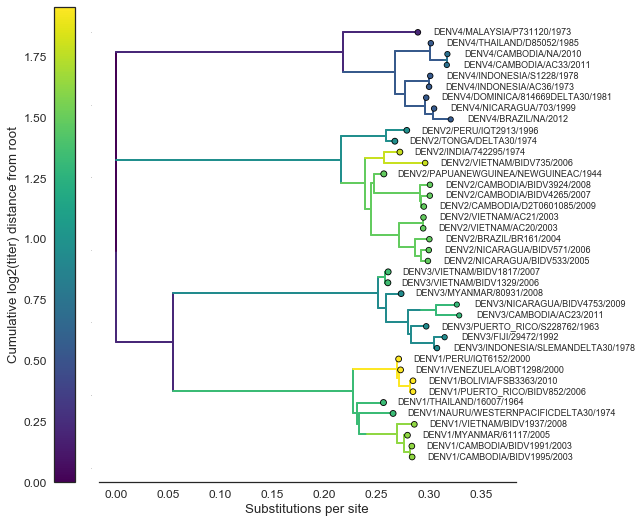

In [5]:
sns.set(style='white', font_scale=1.2)
fig, (cax, ax) = plt.subplots(nrows=1, ncols=2, figsize=(7.5,7.5), gridspec_kw={'width_ratios': (0.05, 1.)}) # quarter page

plot_tree(titered_strains_tree, ax, cax)
plt.tight_layout()
plt.savefig('./png/titered_strains_tree.png', dpi=300, bbox_inches='tight')